In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  
plt.rcParams['axes.unicode_minus'] = False  

################################# 数据 读取-处理 开始#################################
sheet = pd.read_excel('data_input/中石化航空煤油Non-Trend_F0.2.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['中石化航空煤油企业结算价Non-Trend/F0.2'].last_valid_index()

sheet.columns  

Index(['中石化航空煤油企业结算价Non-Trend/F0.2', '煤油：产量：中国（周）', 'USDCNH即期汇率',
       'USDCNH拟合残差/中美利差', '石脑油重整利润0.09/0.21/0.26', '山东柴油裂解差/30DMA',
       '南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA'],
      dtype='object')

In [4]:
# 将数据转换为月度数据(月末)
sheet = sheet.resample('ME').mean()
sheet.head()

,中石化航空煤油企业结算价Non-Trend/F0.2,煤油：产量：中国（周）,USDCNH即期汇率,USDCNH拟合残差/中美利差,石脑油重整利润0.09/0.21/0.26,山东柴油裂解差/30DMA,南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA
Date,,,,,,,
2012-03-31,NaN,NaN,NaN,NaN,NaN,-212.945050,NaN
2012-04-30,NaN,NaN,6.300500,-0.347700,NaN,-203.266897,NaN
2012-05-31,NaN,NaN,6.325357,-0.314100,NaN,-170.276735,NaN
2012-06-30,NaN,NaN,6.366071,-0.257652,NaN,-13.919260,NaN
2012-07-31,NaN,NaN,6.371650,-0.251864,NaN,-25.965906,NaN


In [5]:
################################# 处理数据 让他们更适合 用来预测之后一个月的数据  #################################

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=2, freq='ME')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='ME')
sheet = sheet.reindex(sheet.index.union(new_index))
# 所有数据截止到target_end
sheet = sheet[sheet.index <= target_end]
sheet


,中石化航空煤油企业结算价Non-Trend/F0.2,煤油：产量：中国（周）,USDCNH即期汇率,USDCNH拟合残差/中美利差,石脑油重整利润0.09/0.21/0.26,山东柴油裂解差/30DMA,南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA
2012-03-31,NaN,NaN,NaN,NaN,NaN,-212.945050,NaN
2012-04-30,NaN,NaN,6.300500,-0.347700,NaN,-203.266897,NaN
2012-05-31,NaN,NaN,6.325357,-0.314100,NaN,-170.276735,NaN
2012-06-30,NaN,NaN,6.366071,-0.257652,NaN,-13.919260,NaN
2012-07-31,NaN,NaN,6.371650,-0.251864,NaN,-25.965906,NaN
...,...,...,...,...,...,...,...
2025-01-31,-23.5882,108.349120,7.316276,0.034487,76.076025,393.940616,-16.400789
2025-02-28,340.2193,120.987500,7.280815,0.026960,85.716700,354.990942,-53.423039
2025-03-31,-40.5904,120.912500,7.252443,0.042214,67.959700,560.491071,-99.500690
2025-04-30,NaN,113.553525,7.304820,0.074532,64.341071,688.267955,-131.776881


In [6]:


################################# 处理缺失值 #################################
fill_methods = {
'煤油：产量：中国（周）':'interpolate', 
'USDCNH即期汇率':'interpolate',
'USDCNH拟合残差/中美利差':'interpolate', 
'石脑油重整利润0.09/0.21/0.26':'interpolate', 
'山东柴油裂解差/30DMA':'interpolate',
'南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA':'interpolate'
} 
sheet= fill_missing_values(sheet, fill_methods, return_only_filled=False)
# sheet.loc[:last_day, '天然气TTF连1价格Non-Trend/F0.1'] = sheet.loc[:last_day, '天然气TTF连1价格Non-Trend/F0.1'].interpolate(method='linear')

#################################  因子处理  #################################

sheet['煤油：产量：中国（周）_提前20天'] = sheet['煤油：产量：中国（周）'].shift(20)
sheet['USDCNH即期汇率_提前20天'] = sheet['USDCNH即期汇率'].shift(40)
sheet['USDCNH拟合残差/中美利差_提前60天'] = sheet['USDCNH拟合残差/中美利差'].shift(60)
sheet['石脑油重整利润0.09/0.21/0.26_提前30天'] = sheet['石脑油重整利润0.09/0.21/0.26'].shift(30)
sheet['山东柴油裂解差/30DMA_提前20天'] = sheet['山东柴油裂解差/30DMA'].shift(20)
sheet['南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA_提前50天'] = sheet['南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA'].shift(50)


sheet['煤油：产量：中国（周）_提前20天_逆序'] = reverse_column(sheet, '煤油：产量：中国（周）_提前20天')
################################# 数据筛选  #################################

sheet_daily = sheet.reset_index().rename(columns={'index': 'Date'})
sheet_daily['Date'] = pd.to_datetime(sheet_daily['Date'])

sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-01-01')]

sheet_daily = sheet_daily.reset_index(drop=True)
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['中石化航空煤油企业结算价Non-Trend/F0.2'].notna())
]

################################# 数据 读取-处理 结束 #################################

In [7]:
sheet_daily.tail()

,Date,中石化航空煤油企业结算价Non-Trend/F0.2,煤油：产量：中国（周）,USDCNH即期汇率,USDCNH拟合残差/中美利差,石脑油重整利润0.09/0.21/0.26,山东柴油裂解差/30DMA,南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA,煤油：产量：中国（周）_提前20天,USDCNH即期汇率_提前20天,USDCNH拟合残差/中美利差_提前60天,石脑油重整利润0.09/0.21/0.26_提前30天,山东柴油裂解差/30DMA_提前20天,南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA_提前50天,煤油：产量：中国（周）_提前20天_逆序
24,2025-01-31,-23.5882,108.349120,7.316276,0.034487,76.076025,393.940616,-16.400789,90.6099,6.456493,0.240735,199.748450,819.385200,-990.315386,79.15135
25,2025-02-28,340.2193,120.987500,7.280815,0.026960,85.716700,354.990942,-53.423039,104.7820,6.420462,0.318675,210.766614,711.222857,-778.264717,64.97925
26,2025-03-31,-40.5904,120.912500,7.252443,0.042214,67.959700,560.491071,-99.500690,113.3500,6.389343,0.414314,199.564295,467.868419,-674.456655,56.41125
27,2025-04-30,NaN,113.553525,7.304820,0.074532,64.341071,688.267955,-131.776881,120.7975,6.373813,0.478359,181.548525,534.316143,-801.570487,48.96375
28,2025-05-31,NaN,115.438760,7.209000,-0.037632,78.319275,720.497879,-126.014395,124.5320,6.362267,0.535310,129.233341,498.402880,-641.301396,45.22925


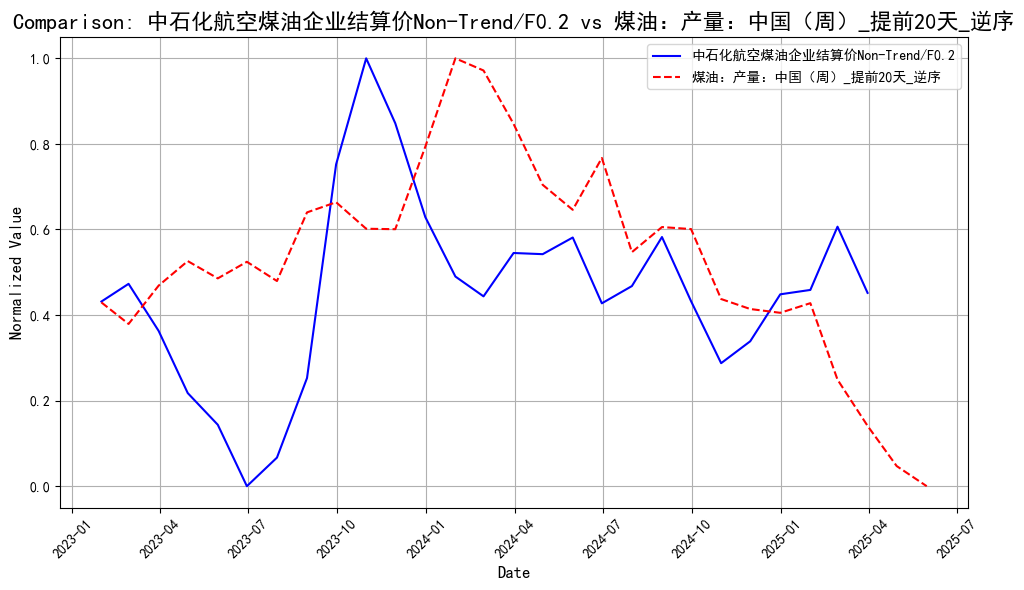

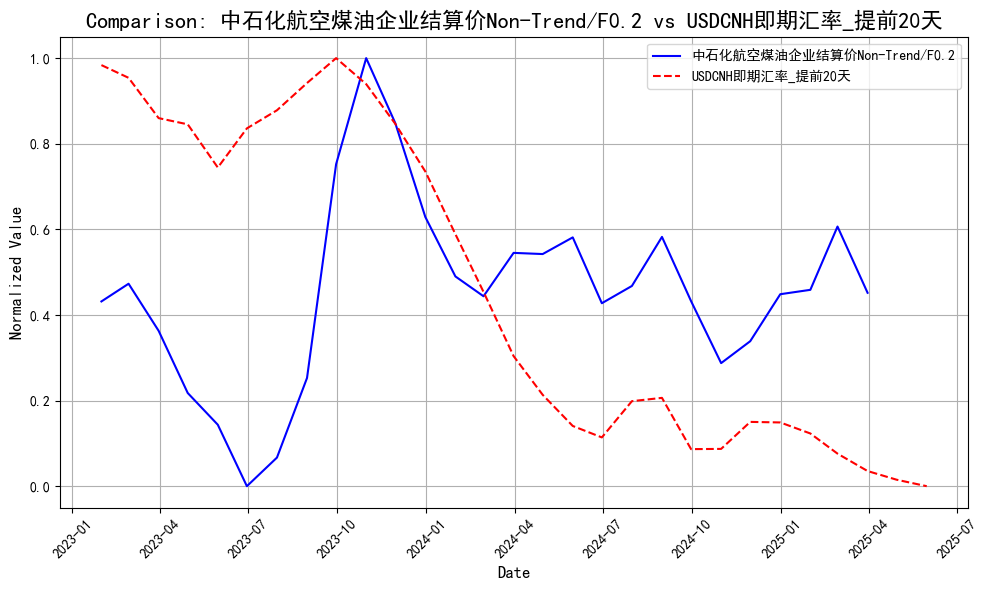

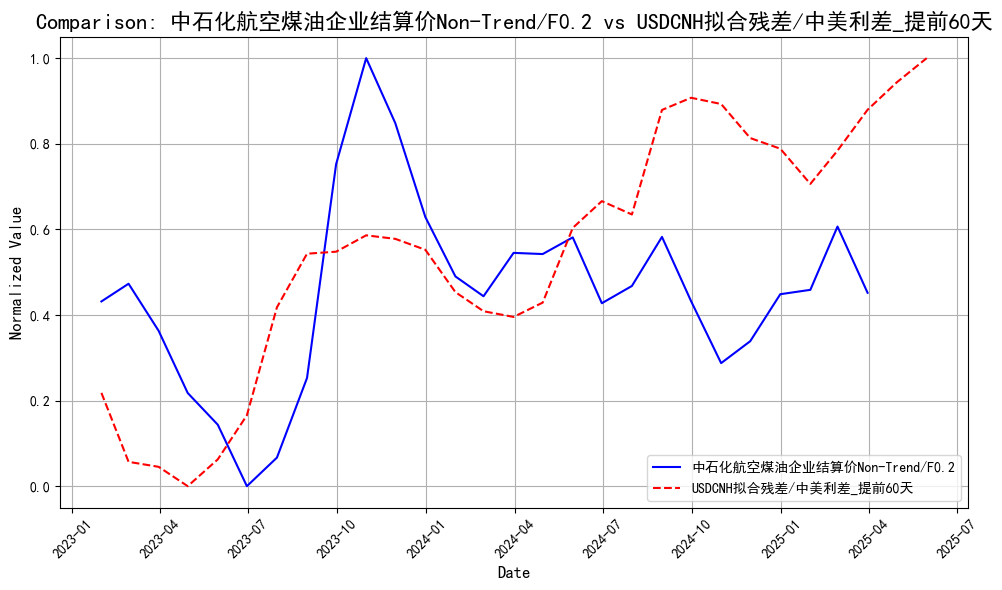

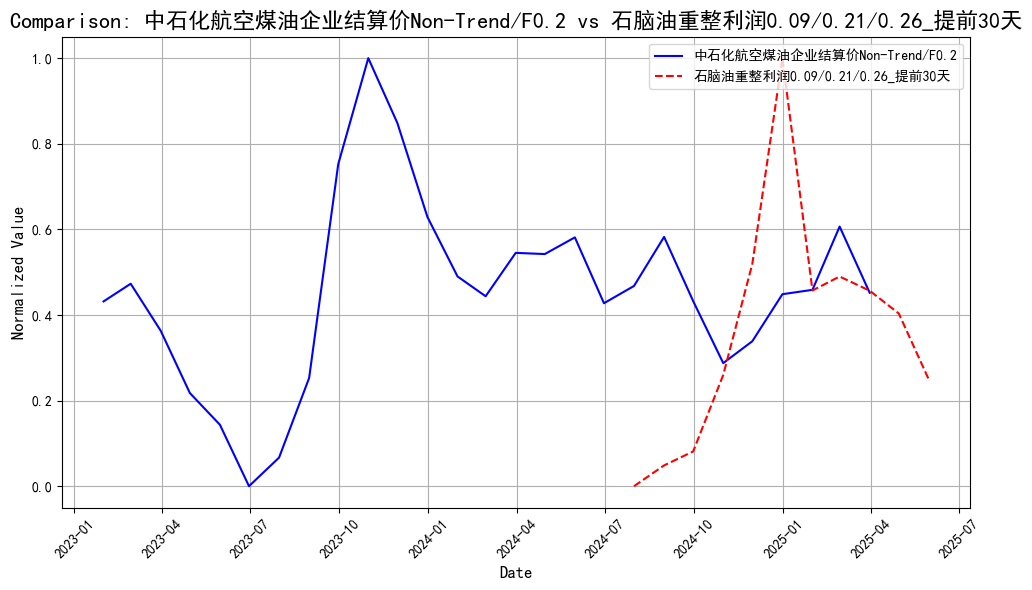

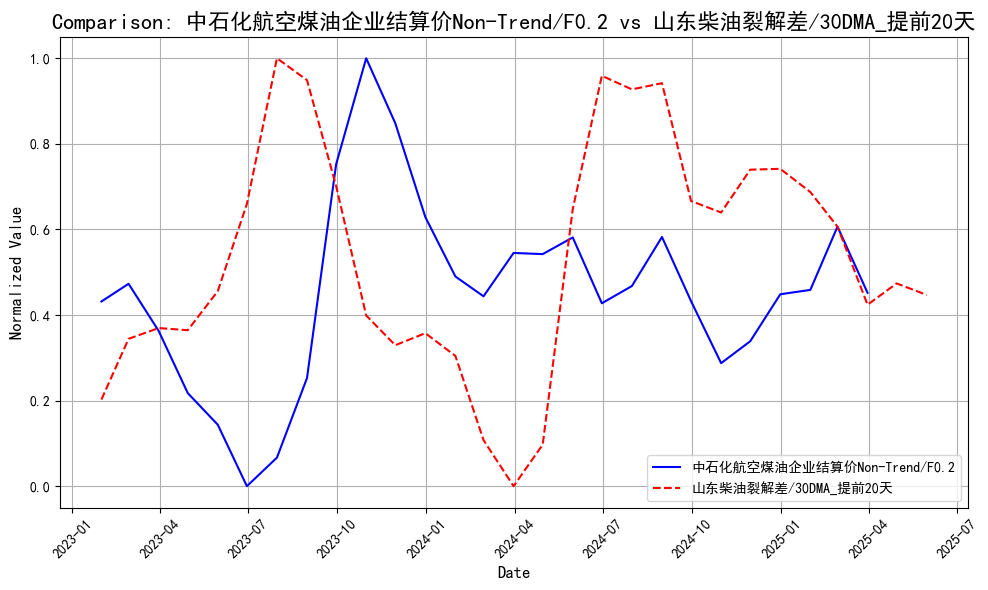

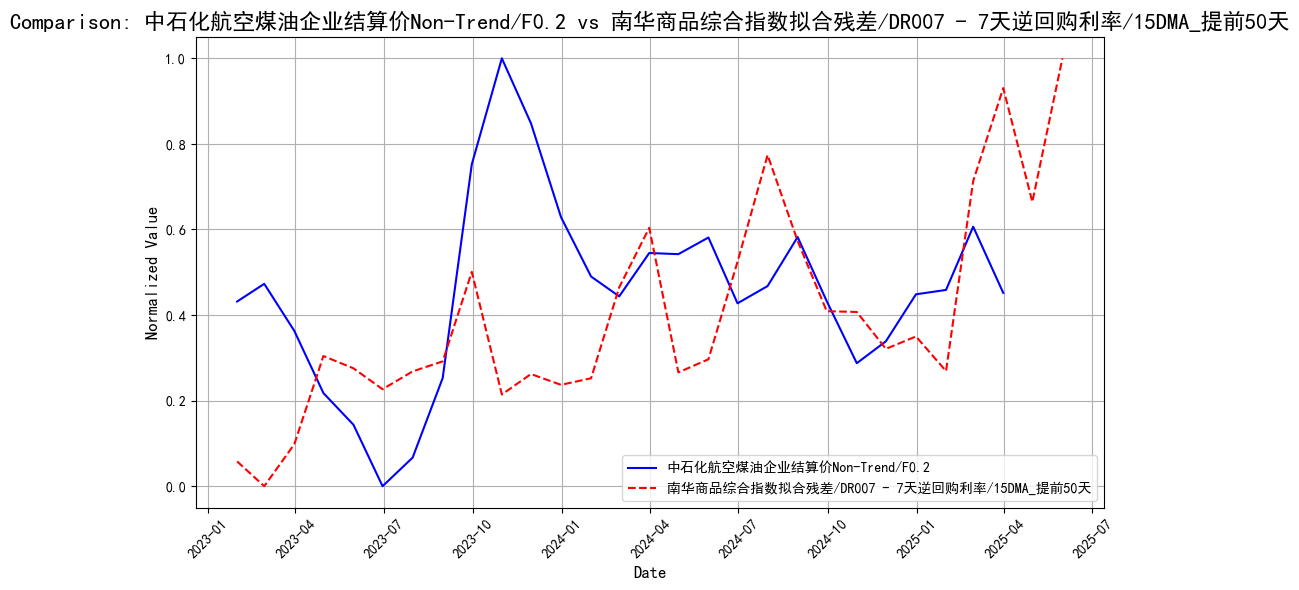

In [8]:
################################# X 和 Y 对比 观察领先性 #################################
data_filtered_plot = sheet_daily.set_index('Date')
plot_comparison_multiple(
    data_filtered_plot, 
    main_col='中石化航空煤油企业结算价Non-Trend/F0.2', 
    compare_cols=[
        '煤油：产量：中国（周）_提前20天_逆序',
        'USDCNH即期汇率_提前20天',
        'USDCNH拟合残差/中美利差_提前60天',
        '石脑油重整利润0.09/0.21/0.26_提前30天',
        '山东柴油裂解差/30DMA_提前20天',
        '南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA_提前50天'
       ]
)

In [9]:
################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 2
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '煤油：产量：中国（周）_提前20天_逆序',
        'USDCNH即期汇率_提前20天',
        'USDCNH拟合残差/中美利差_提前60天',
        '石脑油重整利润0.09/0.21/0.26_提前30天',
        '山东柴油裂解差/30DMA_提前20天',
        '南华商品综合指数拟合残差/DR007 - 7天逆回购利率/15DMA_提前50天'
]

predict_column = '中石化航空煤油企业结算价Non-Trend/F0.2'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]

################################# Xgboost 模型 训练 测试 预测 #################################

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_future_scaled = scaler.transform(X_future)

train_dmatrix_huber = xgb.DMatrix(X_train_scaled, label=y_train)
train_dmatrix_zscore = xgb.DMatrix(X_train_scaled, label=y_train)
test_dmatrix = xgb.DMatrix(X_test_scaled, label=y_test)
future_dmatrix = xgb.DMatrix(X_future_scaled)

# 计算样本权重 - 使用Huber损失函数的思想降低异常值影响
residuals = np.abs(y_train - y_train.mean())
delta = np.percentile(residuals, 90)  # 使用90%分位数作为阈值
sample_weights_huber = np.where(residuals <= delta, 1.0, delta/residuals)
train_dmatrix_huber.set_weight(sample_weights_huber)

# 使用z-score思路计算样本权重
z_scores = np.abs((y_train - y_train.mean()) / y_train.std())
z_threshold = 2.0  # 设置z-score阈值为2个标准差
sample_weights_zscore = np.where(z_scores <= z_threshold, 1.0, z_threshold/z_scores)
train_dmatrix_zscore.set_weight(sample_weights_zscore)

# 设置XGBoost参数
params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.01,  # 学习率
    'max_depth': 6,  # 树的最大深度
    'min_child_weight': 0.82,  # 最小子节点权重
    'subsample': 0.7,  # 样本采样比例
    'colsample_bytree': 0.8,  # 特征采样比例
    'gamma': 0.02,  # 最小分裂损失
    'reg_alpha': 0.6,  # L1正则化
    'reg_lambda': 0.8,  # L2正则化
    'eval_metric': 'rmse',  # 评估指标：选择"rmse"
    'seed': 42  # 随机种子
}



num_boost_round = 5000
evals_result = {}

# 模型训练
model = xgb.train(
    params,
    train_dmatrix_huber,  # 使用带权重的DMatrix
    num_boost_round, # 训练最大轮数
    evals=[(test_dmatrix, 'eval'), (train_dmatrix_huber, 'train')],  # 更新评估数据集
    early_stopping_rounds=100,  # 早停策略：若连续50轮验证集的误差没有改善，则停止训练
    evals_result=evals_result,  # 保存训练过程中的评估结果
    verbose_eval=100 # 每100轮输出一次评估信息
)


y_train_pred_dmatrix = model.predict(train_dmatrix_huber)
y_test_pred_dmatrix = model.predict(test_dmatrix)

train_mse = mean_squared_error(y_train, y_train_pred_dmatrix)
test_mse = mean_squared_error(y_test, y_test_pred_dmatrix)
train_r2 = r2_score(y_train, y_train_pred_dmatrix)
test_r2 = r2_score(y_test, y_test_pred_dmatrix)
print(f"训练集 MSE (DMatrix): {round(train_mse, 4)}, 训练集 R² (DMatrix): {round(train_r2, 4)}")
print(f"测试集 MSE (DMatrix): {round(test_mse, 4)}, 测试集 R² (DMatrix): {round(test_r2, 4)}")

##### 预测未来 非全部数据 和 结果存储（y_test,y_future） #####
y_future_pred_dmatrix = model.predict(future_dmatrix)
test_data.loc[:, '预测值'] = y_test_pred_dmatrix
future_data.loc[:, '预测值'] = y_future_pred_dmatrix

[0]	eval-rmse:282.09227	train-rmse:519.29778


[100]	eval-rmse:302.31837	train-rmse:309.54922


[200]	eval-rmse:305.84011	train-rmse:190.88216


[300]	eval-rmse:307.41069	train-rmse:128.55847


[400]	eval-rmse:307.40038	train-rmse:87.14733


[500]	eval-rmse:307.87015	train-rmse:65.69808


[600]	eval-rmse:307.16131	train-rmse:50.94921


[700]	eval-rmse:304.20713	train-rmse:40.41301


[800]	eval-rmse:304.36852	train-rmse:33.41030


[900]	eval-rmse:304.21707	train-rmse:27.48823


[1000]	eval-rmse:301.34637	train-rmse:22.74863


[1100]	eval-rmse:299.35998	train-rmse:19.30886


[1200]	eval-rmse:297.82707	train-rmse:16.27929


[1300]	eval-rmse:295.41571	train-rmse:13.52325


[1400]	eval-rmse:295.08831	train-rmse:11.66982

[1500]	eval-rmse:293.85241	train-rmse:9.89609


[1600]	eval-rmse:292.94739	train-rmse:8.28413


[1700]	eval-rmse:292.42250	train-rmse:6.98666


[1800]	eval-rmse:291.76112	train-rmse:6.06858


[1900]	eval-rmse:291.31099	train-rmse:5.10320


[2000]	eval-rmse:291.06498	train-rmse:4.36760


[2100]	eval-rmse:290.98012	train-rmse:3.68259


[2200]	eval-rmse:290.95314	train-rmse:3.10402


[2300]	eval-rmse:290.75344	train-rmse:2.63936


[2400]	eval-rmse:290.60316	train-rmse:2.26268


[2500]	eval-rmse:290.47127	train-rmse:1.94589


[2600]	eval-rmse:290.37666	train-rmse:1.65776


[2700]	eval-rmse:290.31733	train-rmse:1.43277


[2800]	eval-rmse:290.27686	train-rmse:1.23168


[2900]	eval-rmse:290.23155	train-rmse:1.08659


[3000]	eval-rmse:290.17612	train-rmse:0.95630


[3100]	eval-rmse:290.13618	train-rmse:0.84348


[3200]	eval-rmse:290.12817	train-rmse:0.75466


[3300]	eval-rmse:290.11312	train-rmse:0.66726


[3400]	eval-rmse:290.10019	train-rmse:0.59602


[3500]	eval-rmse:290.06788	train-rmse:0.53587


[3600]	eval-rmse:290.01776	train-rmse:0.48070


[3700]	eval-rmse:289.99907	train-rmse:0.44249


[3800]	eval-rmse:289.96282	train-rmse:0.40193


[3900]	eval-rmse:289.93049	train-rmse:0.36888


[4000]	eval-rmse:289.90249	train-rmse:0.34184


[4100]	eval-rmse:289.87388	train-rmse:0.32705


[4200]	eval-rmse:289.85556	train-rmse:0.31559


[4300]	eval-rmse:289.84598	train-rmse:0.30372


[4400]	eval-rmse:289.83588	train-rmse:0.29549


[4500]	eval-rmse:289.82365	train-rmse:0.29031


[4600]	eval-rmse:289.81926	train-rmse:0.28523


[4700]	eval-rmse:289.81489	train-rmse:0.28047


[4800]	eval-rmse:289.80759	train-rmse:0.27682


[4900]	eval-rmse:289.80013	train-rmse:0.27365


[4999]	eval-rmse:289.79830	train-rmse:0.27214


训练集 MSE (DMatrix): 0.0892, 训练集 R² (DMatrix): 1.0
测试集 MSE (DMatrix): 83983.0506, 测试集 R² (DMatrix): -1.3165


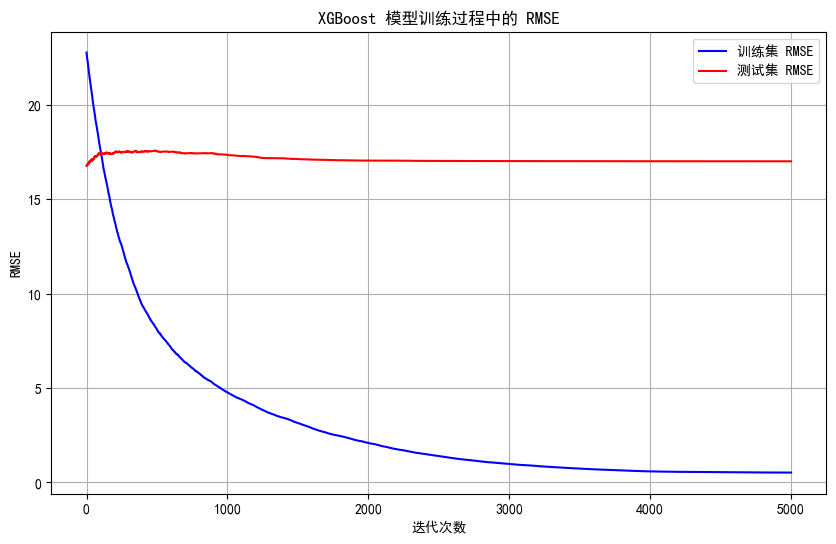

In [10]:
# 可视化训练过程中的评估指标
plt.figure(figsize=(10, 6))
train_rmse = np.sqrt(evals_result['train']['rmse'])
test_rmse = np.sqrt(evals_result['eval']['rmse'])

epochs = len(train_rmse)
x_axis = range(epochs)

plt.plot(x_axis, train_rmse, label='训练集 RMSE', color='blue')
plt.plot(x_axis, test_rmse, label='测试集 RMSE', color='red')

plt.xlabel('迭代次数')
plt.ylabel('RMSE')
plt.title('XGBoost 模型训练过程中的 RMSE')
plt.legend()
plt.grid(True)
plt.show()

In [11]:
################################# Xgboost 模型 训练 测试 预测 所有数据 #################################
X_all = pd.concat([X_train, X_test]).reset_index(drop=True)
y_all = pd.concat([y_train, y_test]).reset_index(drop=True)

X_all_scaled = scaler.transform(X_all)
X_future_scaled = scaler.transform(X_future)

all_data_dmatrix = xgb.DMatrix(X_all_scaled, label=y_all)
future_dmatrix_all = xgb.DMatrix(X_future_scaled)

# 计算所有数据的样本权重
residuals_all = np.abs(y_all - y_all.mean())
sample_weights_all = np.where(residuals_all <= delta, 1.0, delta / residuals_all)

all_data_dmatrix.set_weight(sample_weights_all)  # 加入样本权重


# 训练模型
model_all = xgb.train(
    params,
    all_data_dmatrix,
    num_boost_round,
    evals=[(all_data_dmatrix, 'train')],
    early_stopping_rounds=50,
    evals_result=evals_result,
    verbose_eval=100
)

y_all_pred = model_all.predict(all_data_dmatrix)
y_future_pred_all = model_all.predict(future_dmatrix_all)

all_mse = mean_squared_error(y_all, y_all_pred)
all_r2 = r2_score(y_all, y_all_pred)

print(f"全部数据 MSE: {round(all_mse, 4)}, 全部数据 R²: {round(all_r2, 4)}")

# 存储全部数据的预测结果
all_data = pd.concat([train_data, test_data]).reset_index(drop=True)
all_data.loc[:, '预测值_全量'] = y_all_pred
future_data.loc[:, '预测值_全量'] = y_future_pred_all

[0]	train-rmse:505.50979


[100]	train-rmse:301.21300


[200]	train-rmse:184.26132


[300]	train-rmse:124.68564


[400]	train-rmse:84.53381


[500]	train-rmse:62.76607


[600]	train-rmse:47.50919


[700]	train-rmse:37.27529


[800]	train-rmse:30.92092


[900]	train-rmse:25.34908


[1000]	train-rmse:20.93292


[1100]	train-rmse:17.77795


[1200]	train-rmse:14.94460


[1300]	train-rmse:12.42562


[1400]	train-rmse:10.70882


[1500]	train-rmse:9.08772


[1600]	train-rmse:7.59255


[1700]	train-rmse:6.40872


[1800]	train-rmse:5.53866


[1900]	train-rmse:4.65322


[2000]	train-rmse:3.98345


[2100]	train-rmse:3.34309


[2200]	train-rmse:2.81048


[2300]	train-rmse:2.38249


[2400]	train-rmse:2.03867


[2500]	train-rmse:1.75709


[2600]	train-rmse:1.49565


[2700]	train-rmse:1.29679


[2800]	train-rmse:1.11275


[2900]	train-rmse:0.98293


[3000]	train-rmse:0.86307


[3100]	train-rmse:0.76316


[3200]	train-rmse:0.68704


[3300]	train-rmse:0.61028


[3400]	train-rmse:0.54449


[3500]	train-rmse:0.49083


[3600]	train-rmse:0.43993


[3700]	train-rmse:0.40248


[3800]	train-rmse:0.36409


[3900]	train-rmse:0.33648


[4000]	train-rmse:0.31480


[4100]	train-rmse:0.30529


[4200]	train-rmse:0.29495


[4300]	train-rmse:0.28662


[4400]	train-rmse:0.27923


[4500]	train-rmse:0.27438


[4600]	train-rmse:0.27140


[4700]	train-rmse:0.26827


[4800]	train-rmse:0.26473


[4900]	train-rmse:0.26302


[4999]	train-rmse:0.26072


全部数据 MSE: 0.081, 全部数据 R²: 1.0


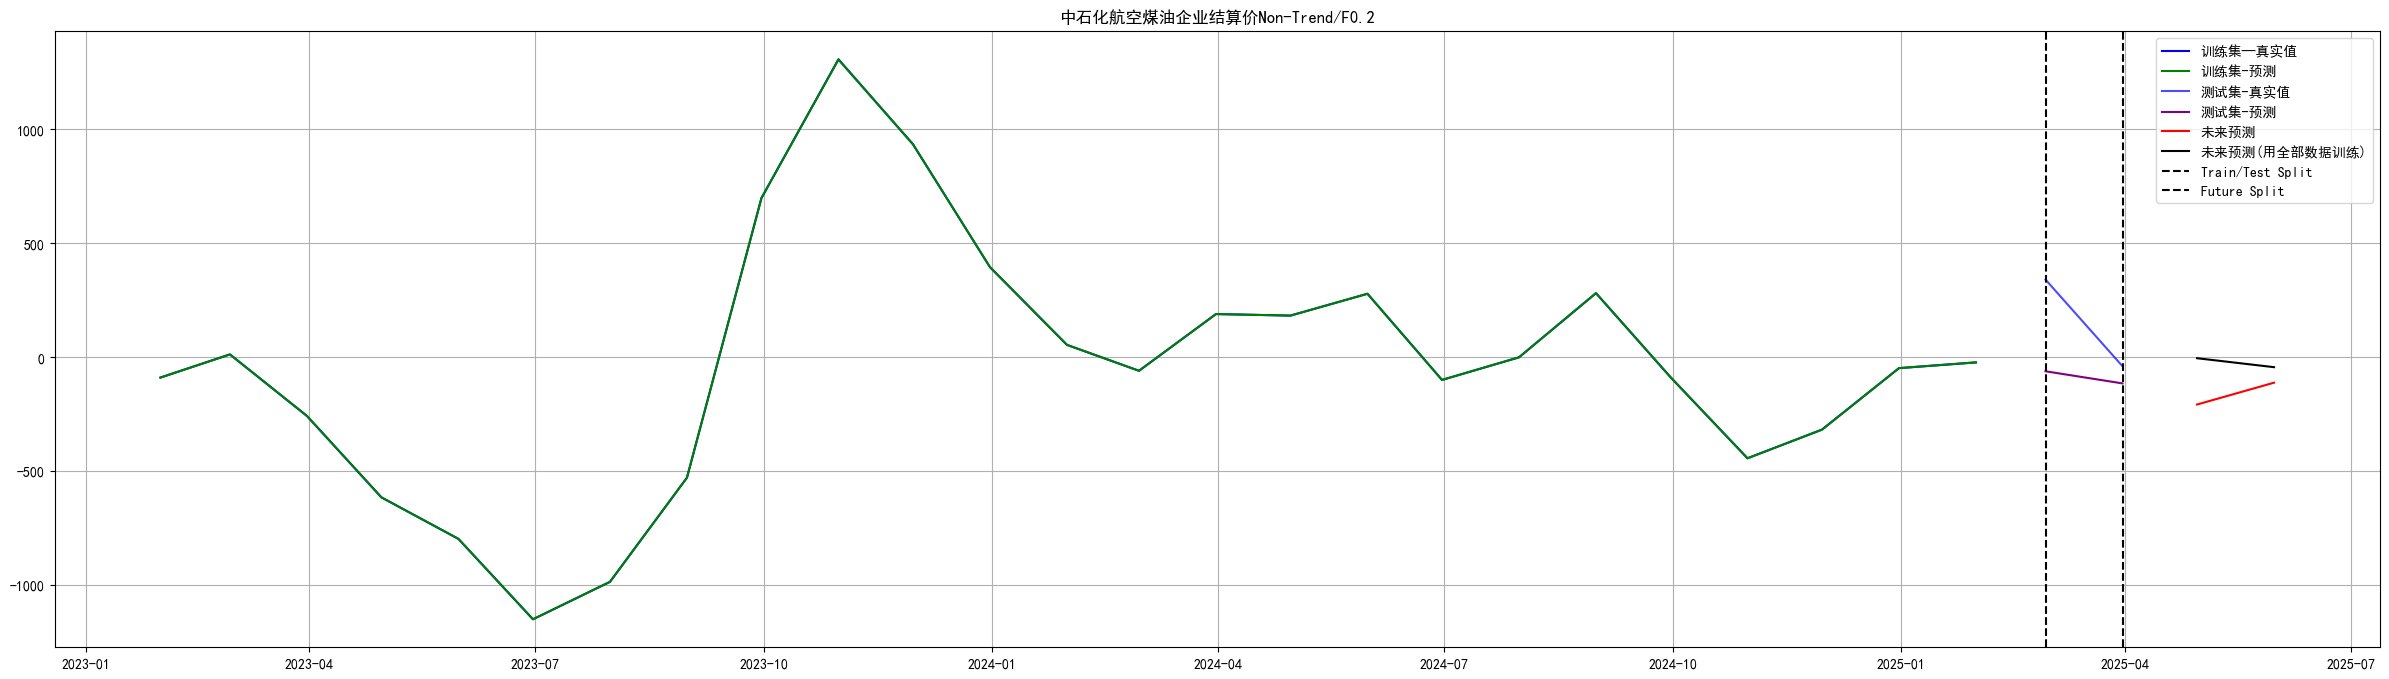

In [12]:
plt.figure(figsize=(30, 8))
# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], y_train_pred_dmatrix, label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred_dmatrix, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], future_data['预测值'], label='未来预测', color='red')
plt.plot(future_data['Date'], future_data['预测值_全量'], label='未来预测(用全部数据训练)', color='black')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('中石化航空煤油企业结算价Non-Trend/F0.2')
plt.legend()
plt.grid(True)
plt.show()


---

In [13]:
################################# 训练预测数据 excel格式输出  #################################
'''
1. 日度数据 （真实值 和 预测值）
2. 月度数据 （真实值、训练值、预测值）
'''

############ 日度 数据 ############
# 创建日度数据框
historical_actual_daily = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 只保留2023年之后的数据
historical_actual_daily = historical_actual_daily[historical_actual_daily['Date'].dt.year >= 2023]
# 创建预测数据框
future_pred_daily = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})


merged_df_daily = pd.merge(historical_actual_daily, future_pred_daily, on='Date', how='outer')
merged_df_daily = merged_df_daily.sort_values('Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/中石化航空煤油企业结算价Non-Trend—F0.2_合并数据.xlsx', index=False,float_format='%.4f')

merged_df_daily 

,Date,真实值,预测值
28,2025/05/31,NaN,-44.576263
27,2025/04/30,NaN,-5.231337
26,2025/03/31,-40.5904,NaN
25,2025/02/28,340.2193,NaN
24,2025/01/31,-23.5882,NaN
23,2024/12/31,-48.7606,NaN
22,2024/11/30,-318.9924,NaN
21,2024/10/31,-444.9687,NaN
20,2024/09/30,-88.4377,NaN
19,2024/08/31,280.7442,NaN


In [14]:
############ 月度 数据 ############
# 历史真实值
historical_actual_monthly = pd.DataFrame({
    'Date': pd.concat([train_data['Date'], test_data['Date']]),
    '真实值': pd.concat([y_train, y_test])
})
# 真实数据 只保留2023年之后的
historical_actual_monthly = historical_actual_monthly[historical_actual_monthly['Date'].dt.year >= 2023]
# 2024年及以后训练集预测值
train_pred_2024 = pd.DataFrame({
    'Date': train_data[train_data['Date'].dt.year >= 2024]['Date'],
    '预测值': y_train_pred_dmatrix[train_data['Date'].dt.year >= 2024]
})
# 2024年及以后c测试集集预测值
test_pred_2024 = test_data[['Date', '预测值']].copy()
# 未来预测值 
future_pred_2024 = pd.DataFrame({
    'Date': future_data['Date'],
    '预测值': future_data['预测值_全量']
})
# 合并 训练集预测+测试集预测+未来预测
future_pred_monthly = pd.concat([
    train_pred_2024, 
    test_pred_2024, 
    future_pred_2024
    ], axis=0).sort_values('Date')

# 合并历史真实值和预测值
merged_df_monthly = pd.merge(historical_actual_monthly, future_pred_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
# 保存成excel
merged_df_monthly.to_excel('eta/中石化航空煤油企业结算价Non-Trend-F0.2_月度数据.xlsx', index=False, float_format='%.4f')
merged_df_monthly

,Date,真实值,预测值
28,2025/05/31,NaN,-44.576263
27,2025/04/30,NaN,-5.231337
26,2025/03/31,-40.5904,-115.909294
25,2025/02/28,340.2193,-62.636959
24,2025/01/31,-23.5882,-23.575226
23,2024/12/31,-48.7606,-48.812214
22,2024/11/30,-318.9924,-319.042053
21,2024/10/31,-444.9687,-444.942505
20,2024/09/30,-88.4377,-88.477478
19,2024/08/31,280.7442,280.806152


---

In [15]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "中石化航空煤油企业结算价Non-Trend/F0.2"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [16]:
'''
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "中石化航空煤油企业结算价Non-Trend/F0.2"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Lcel import update_excel_data\nfile_path = "eta/1.汽柴煤油_数据上传.xlsx"\nsheet_name = "详情页"\nidentifier = "中石化航空煤油企业结算价Non-Trend/F0.2"       # NEW: 新增日期标识符列的抬头\n# 调用函数更新数据\nsuccess = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'